# Bayesian Multiple regression

In this next chapter, we'll be extending the bivariate regression from chapter 4 to include multiple predictor variables (instead of just the one 'weight' predictor from the previous chapter. Doing this throws up some intresting opportunities and challenges. Namely CONFOUNDING VARIABLES. How can we be sure that every predictor variable can indpendently cause the output variable?

As mentioned in the title, we are going to be doing lots of MULTIPLE REGRESSION. Reasons given for multiple regression models include

 - Statistical "Control" for confounds. A confound is something that misleads us about a causal influence - there will be a more precise definition in the next chapter. The spurious waffles and divorce correlation is one possible type of confound, where confound (southernness) makes a variables with no real importance (waffle house density) appear to be important. But confounds are diverse. They can hide real important variables just as easily as they can produce false ones.
 
 - Multiple causation. A phenomoneon may arise from multiple causes. Measurement of each cause is useful, so when we can use the same data to estimate more than one type of influence we should. Furthermore, when causation is multiple, one cause can hide another.
 
 - Interations. The importance of one variable may depend on another. For example plants depend on both light and water. But in the absense of either, the other is of no benefit at all. Such interactions occur very often. Effective inference about one variable will often depend upon the consideration of others.
 
 In this chapter, we beigin to deal with the first of these two, using multiple regression to deal with simple confounds and take multiple measurements of association. You'll see how to include any arbitary number of 'main effects' in your linear model of the gaussian mean. These main effects are additive combinations of variables, the simplest type of multivariable model. We'll focus on two valuable things these models can help us with: (1) revealing spurius correlations like the Waffle House correlation with divorce and (2) revealing important correlations that may be 'masked' by unrevealed correlations and other variables.
 
 However, multiple regression can be worse than useless if you don't know how to use it. Just adding variables to a model can do a lot of damage. So in this chapter, we'll begin to think formally about causal inference and introduce graphical causal models as a way to design and interpret regression models.

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

## Code 5.1

In [37]:
# load data
df = pd.read_csv('WaffleDivorce.csv', sep=';')
# standardize predictor
df['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()
df['Divorce_s'] = (d.Divorce - d.Divorce.mean()) / d.Divorce.std()
df['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [36]:
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_s,Divorce_s
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.610716
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,2.093569
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.927058


In [23]:
with pm.Model() as model_5_1:
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    betaA = pm.Normal('betaA', mu=0, sd=0.5)
    
    
    mu = pm.Deterministic('mu', alpha + betaA * df.MedianAgeMarriage_s)
    sigma = pm.Exponential('sigma', lam=1)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=df.Divorce_s)
    
    # Sample from priors to see what results we are open to before we do the analysis
    prior_checks = pm.sample_prior_predictive(samples=50)
    
    # sample from the data to obtain our posterior
    trace_5_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, betaA, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:04<00:00, 1659.69draws/s]


Divorce is the standardised (zero centered, standard deviation one) divorce rate for state i, and Ai is the standardised median age at marriage. The linear model structure should be familiar from the previous chapter.

What about those priors? since the outcome and predictor variable are both standardised, the intercept alpha should end up being very close to zero. What does the prior slope betaA imply? If betaA=1, that would imply that a change of one standard deviation in age at marriage is associated likewise with a change of one standard deviation in divorce.

Below we plot the samples we took from out prior using 'pm.sample_prior_predictive' to see what our model is expecting before we see the data. As yoiu can see these are weakly informative priors in tht they allow some implausably string relationships but generally bound the lines to possible ranges of the variables

## Prior Predictive Plots

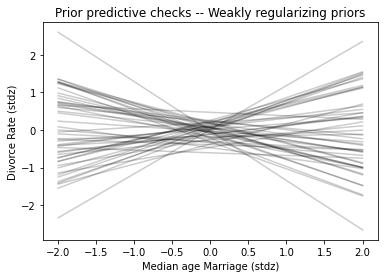

In [33]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["alpha"], prior_checks["betaA"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.2)

ax.set_xlabel("Median age Marriage (stdz)")
ax.set_ylabel("Divorce Rate (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

# Posterior Plots

/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages

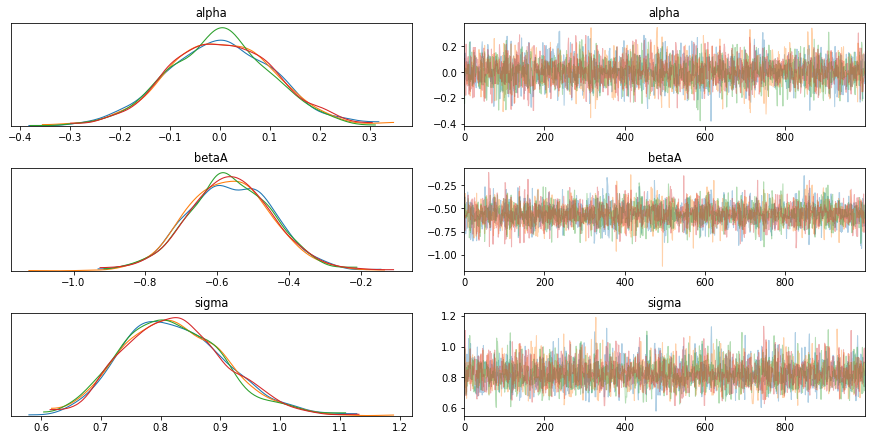

In [34]:
varnames = ['alpha', 'betaA', 'sigma']
pm.traceplot(trace_5_1, varnames);

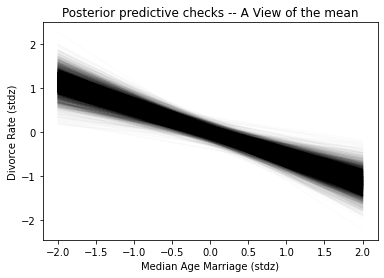

In [35]:
_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(trace_5_1["alpha"], trace_5_1["betaA"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.01)

ax.set_xlabel("Median Age Marriage (stdz)")
ax.set_ylabel("Divorce Rate (stdz)")
ax.set_title("Posterior predictive checks -- A View of the mean");

In [40]:
pm.summary(trace_5_1, varnames).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.002,0.104,-0.198,0.197,0.002,0.002,4471.0,2221.0,4471.0,3246.0,1.0
betaA,-0.564,0.117,-0.776,-0.338,0.002,0.001,5338.0,5338.0,5389.0,2966.0,1.0
sigma,0.823,0.085,0.671,0.984,0.001,0.001,4154.0,4107.0,4141.0,2784.0,1.0


the traceplot, and the posterior regression plots show beta as being reliably negative.
If can fit a similar regression model for the relationship between marriage rate and divorce rate. But as the fugure below shows, this relationship isn't as strong as the previous one. 
But merely comparing parameter means between different bivariate regressions is no way to decide which predictor is better. Both of these predictors could provide idependent value, or they could be redundant, or one could eliminate the value of the other.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, betaA, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2132.67draws/s]


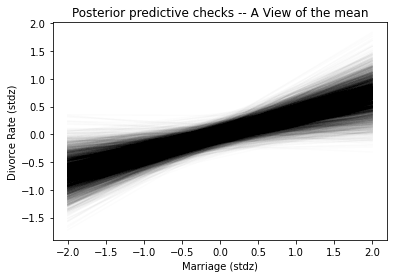

In [39]:

with pm.Model() as model_5_1_b:
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    betaA = pm.Normal('betaA', mu=0, sd=0.5)
    
    
    mu = pm.Deterministic('mu', alpha + betaA * df.Marriage_s)
    sigma = pm.Exponential('sigma', lam=1)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=df.Divorce_s)
    
    
    # sample from the data to obtain our posterior
    trace_5_1_b = pm.sample(1000, tune=1000)
    
# Plotting the posterior

_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(trace_5_1_b["alpha"], trace_5_1_b["betaA"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.01)

ax.set_xlabel("Marriage (stdz)")
ax.set_ylabel("Divorce Rate (stdz)")
ax.set_title("Posterior predictive checks -- A View of the mean");

To make sense of this, we are going to have to think causally. And then, only after we've done some thinking, a bigger regression model that includes both age at marriage and marriage rate will help us

## Multiple regression notation

Multiple regression formulas look a lot like the polynomial models at the end of the previous chapter - they add more parameters and variables to the definition of mu. The strategy is straightforward:
 - Nominate the predictor variables you want in the linear model of the mean
 - for each predictor, make a parametrer that will measure its association with the outcome
 - multiply the parameter by the variable and add that term to the linear model
 

In [41]:
with pm.Model() as model_5_1_c:
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    betaA = pm.Normal('betaA', mu=0, sd=0.5)
    betaM = pm.Normal('betaM', mu=0, sd=0.5)
    
    
    mu = pm.Deterministic('mu', alpha + betaA * df.MedianAgeMarriage_s + betaM * df.Marriage_s)
    sigma = pm.Exponential('sigma', lam=1)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=df.Divorce_s)
    
    
    # sample from the data to obtain our posterior
    trace_5_1_c = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, betaM, betaA, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:05<00:00, 1549.68draws/s]


/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages

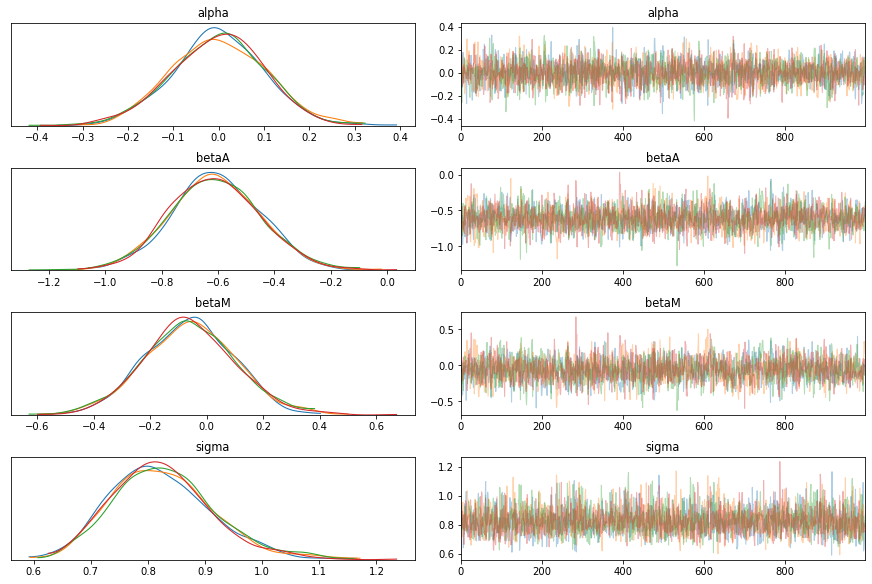

In [43]:
varnames = ['alpha', 'betaA','betaM', 'sigma']
pm.traceplot(trace_5_1_c, varnames);

In [44]:
pm.summary(trace_5_1_c, varnames).round(3)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.001,0.101,-0.190,0.190,0.002,0.001,3243.0,2296.0,3247.0,2666.0,1.0
betaA,-0.608,0.158,-0.912,-0.324,0.003,0.002,2627.0,2627.0,2641.0,2710.0,1.0
betaM,-0.060,0.160,-0.368,0.237,0.003,0.002,2480.0,2221.0,2488.0,2418.0,1.0
sigma,0.827,0.088,0.663,0.985,0.002,0.001,3233.0,3186.0,3262.0,2626.0,1.0


The posterior mean for marriage rate, betaM, is now close to zero, with plenty of probability on both sides of zero. The posterior mean for age at marriage, bA, is essentially unchanged. You can interpret these distributions as saying:

Once we know the median age at marriage for a state, there is little or no additional predictive power in also knowing the rate of marriage in that state.

Divorce rate is independent of Marriage rate, conditional on already knowing age of marriage

Note that this does not mean that there is no value in knowing marriage rate. Consistent with the earlier DAG, if you didn't have access to age-at-marriage data, then you'd definitely find value in knowing the marriage rate. This implies there is no, or almost no direct causal path from marriage rate to divorse rate. The association between marriage rate and divorce rate is spurious, caused by the inpluence of age of marriage on both marriage rate and divorce rate. 